### Project Overview: Stock Sentiment, Predicting market behavior from tweets

The goal of this project is to predict market behavior from tweets.

To evaluate the tweets, they are classiefied according to the following labels:

- **.Bearish (0)**: Negative sentiment
- **.Bullish (1)**: Positive sentiment
- **.Neutral (2)**: No sentiment

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import re
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from nltk.stem import PorterStemmer
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification, create_optimizer




In [72]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from transformers import BertTokenizer, TFBertForSequenceClassification

In [73]:
# 🧠 Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [74]:
#!pip install nltk
#!pip install strings

In [75]:
train = pd.read_csv("train.csv")

In [76]:
test = pd.read_csv("test.csv")

# EDA

In [77]:
train.head(10)

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
5,$FTI - TechnipFMC downgraded at Berenberg but ...,0
6,$GM - GM loses a bull https://t.co/tdUfG5HbXy,0
7,$GM: Deutsche Bank cuts to Hold https://t.co/7...,0
8,$GTT: Cowen cuts to Market Perform,0
9,$HNHAF $HNHPD $AAPL - Trendforce cuts iPhone e...,0


In [78]:
train.duplicated().sum()

np.int64(0)

In [79]:
train.shape

(9543, 2)

In [80]:
train.columns

Index(['text', 'label'], dtype='object')

In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


In [82]:
(train['text']).unique()

array(['$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT',
       '$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3',
       '$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb',
       ...,
       'vTv Therapeutics leads healthcare gainers; Myomo and Biohaven Pharmaceutical among losers',
       'WORK, XPO, PYX and AMKR among after hour movers',
       'YNDX, I, QD and OESX among tech movers'], dtype=object)

In [83]:
train.describe()

,label
count,9543.000000
mean,1.496280
std,0.743139
min,0.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,2.000000


From the above table, we can get some conclusions.
- `count`- There are 9543 tweets with valid sentiments.
- `mean`- On average, tweets are more prone to be neutral;
- `std`- Standard deviation (0.74 on a scale from 0 to 2) indicates some diversity, but not perfect balance. It’s skewed toward neutral and bullish.
- `25%, 50%, 75%`- The median, 25%, and 75% percentiles are all ≥ 1, with 50% and 75% being exactly 2
- Since the 25% percentile is 1, only 25% of tweets are either bearish (0) or bullish (1) and given that the mean is 1.5, bearish (0) tweets are likely the least frequent.
- Class 2 (neutral) is overrepresented, and class 0 (bearish) is underrepresented.

In [84]:
label_counts=train['label'].value_counts()
label_percentage=train['label'].value_counts(normalize=True)
summary_df = pd.DataFrame({
    'Count': label_counts,
    'Percentage (%)': label_percentage.round(2)
})

print(summary_df)

       Count  Percentage (%)
label                       
2       6178            0.65
1       1923            0.20
0       1442            0.15


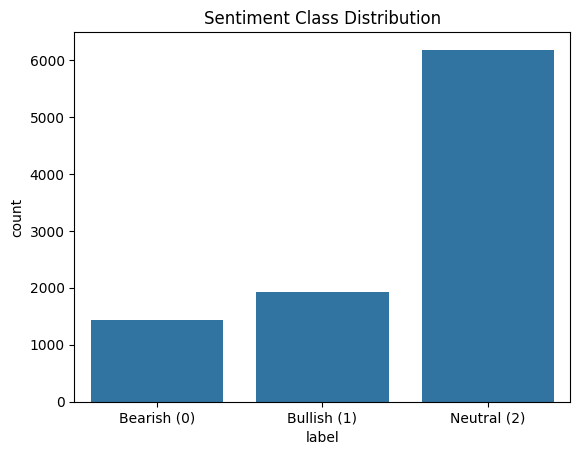

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=train)
plt.title("Sentiment Class Distribution")
plt.xticks(ticks=[0, 1, 2], labels=["Bearish (0)", "Bullish (1)", "Neutral (2)"])
plt.show()

### There is class imbalance in the dataset.

## Categorical

In [86]:
train.describe(include = ['O'])

,text
count,9543
unique,9543
top,"YNDX, I, QD and OESX among tech movers"
freq,1


In [87]:
#Check a random text
train['text'][10]

"$HOG - Moody's warns on Harley-Davidson https://t.co/LurHBEadeU"

In [88]:
train['word_count']  = train['text'].apply(lambda x: len(str(x).split(" ")))
train[['text','word_count']].head()

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10
1,$CCL $RCL - Nomura points to bookings weakness...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14
3,$ESS: BTIG Research cuts to Neutral https://t....,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10


In [89]:
train.word_count.describe()

,word_count
count,9543.000000
mean,12.168081
std,4.651245
min,1.000000
25%,9.000000
50%,11.000000
75%,15.000000
max,31.000000


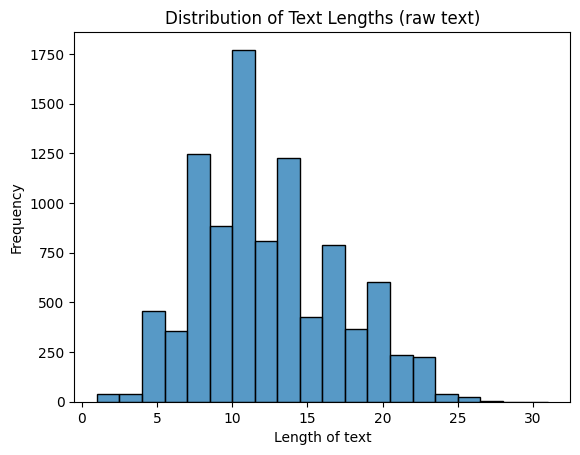

In [90]:
#Plot distribution of text length
sns.histplot(train['word_count'], bins=20)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

### Words per tweet statistics

- `mean`: On average it's written 11 words.
- `std`: Its small, the interval is between 8 and 16.
- `min`: 1 word tweets, can be erased perhaps.
- `75%`: 75% of tweets have 15 words or less.


In [91]:
all_words = ' '.join(train['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

,count
to,2332
the,1820
of,1464
-,1390
in,1361
on,1136
for,1032
a,970
and,898
The,663


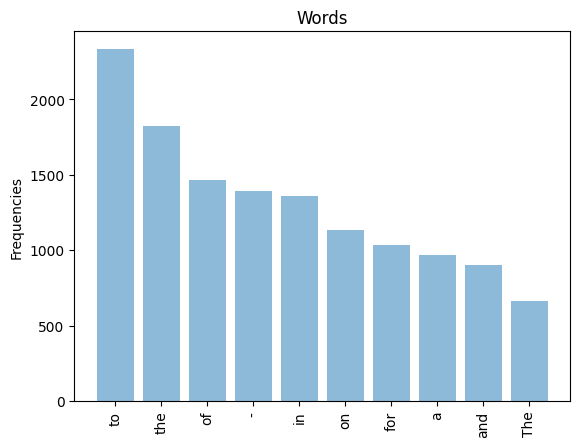

In [92]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

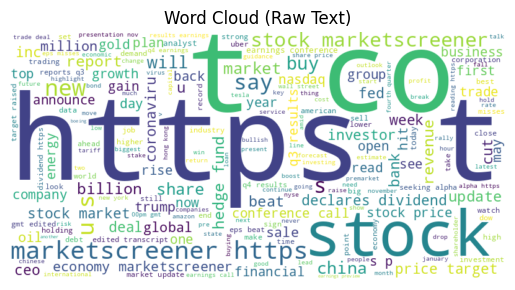

In [93]:
# Create a word cloud from the raw text
raw_text = ' '.join(train['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

In [94]:
count = train['text'].str.strip().str.startswith('$').sum()

print(f"Number of rows where text starts with $: {count}")

Number of rows where text starts with $: 1292


Here we have a lot of nonsense words that start with '$' that may not be useful to our future model


In [95]:
# Count how many rows contain http, https, or www
url_count = train['text'].str.contains(r'(http|https|www)', regex=True).sum()

print(f"Number of phrases containing a URL: {url_count}")

Number of phrases containing a URL: 4470


<ipython-input-95-12421402>:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  url_count = train['text'].str.contains(r'(http|https|www)', regex=True).sum()


URL's like (hhtp, https, www) on our text in most cases are not useful and can be safely removed as well.

In [96]:
# Remove $TICKERs
train['clean_text'] = train['text'].str.replace(r'\$\w+', '', regex=True)

# Remove URLs
#train['clean_text'] = train['clean_text'].str.replace(r'http\S+', '', regex=True)

# Remove leading : or - characters
train['clean_text'] = train['clean_text'].str.replace(r'^[\s:-]+', '', regex=True)

# Normalize spacing
train['clean_text'] = train['clean_text'].str.replace(r'\s+', ' ', regex=True).str.strip()



train['text'] = train['clean_text']
train.drop(columns=['clean_text'], inplace=True)

# Stop words ("English")

In [97]:
stop = set(stopwords.words('english'))

# Lemmanization

In [98]:
lemma = WordNetLemmatizer()

In [99]:
import re
import string
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

stop = set(stopwords.words('english')) - {"not", "but", "no"}  # Keep key negations
lemma = WordNetLemmatizer()
ps = PorterStemmer()

def clean(text_list, lemmatize=True, stemmer=False):
    updates = []
    for j in tqdm(text_list):
        text_lower = j.lower()
        text_lower = re.sub(r"http\S+", "", text_lower)  # Remove URLs
        text_lower = re.sub(r"[^a-zA-Z\s]", "", text_lower)  # Keep only letters
        #text_lower = " ".join([w for w in text_lower.split() if w not in stop])  # Remove stopwords
        text_lower = " ".join([w for w in text_lower.split() if len(w) > 1 and not w.isnumeric()])  # Remove 1-letter words and numbers
        if lemmatize:
            text_lower = " ".join([lemma.lemmatize(w) for w in text_lower.split()])
        if stemmer:
            text_lower = " ".join([ps.stem(w) for w in text_lower.split()])
        updates.append(text_lower)
    return updates

In [100]:
updated_train = clean(train['text'], lemmatize = True, stemmer = False)

100%|██████████| 9543/9543 [00:00<00:00, 21644.78it/s]


In [101]:
updated_train

['jpmorgan reel in expectation on beyond meat',
 'nomura point to booking weakness at carnival and royal caribbean',
 'cemex cut at credit suisse jp morgan on weak building outlook',
 'btig research cut to neutral',
 'funko slide after piper jaffray pt cut',
 'technipfmc downgraded at berenberg but called top pick at deutsche bank',
 'gm loses bull',
 'deutsche bank cut to hold',
 'cowen cut to market perform',
 'trendforce cut iphone estimate after foxconn delay',
 'moody warns on harleydavidson',
 'citing aero tie well slash pt on hexcel',
 'intelsat cut to market perform at raymond james',
 'compass point cut to sell',
 'muddy water go short luckin coffee',
 'mantech downgraded ahead of difficult comp',
 'oppenheimer cut to perform',
 'mplx cut at credit suisse on potential dilution from marathon strategic review',
 'imperial downgrade msg network amid sportsfree airwave',
 'piper hit the materialise sideline',
 'hovde group cut to market perform',
 'new netflix bear step out',
 'sh

In [102]:
#def update_df(dataframe, list_updated):
   # dataframe.update(pd.DataFrame({"text": list_updated}))

In [103]:
train['text'] = updated_train

In [104]:
#update_df(train, updated_train)
train.head()

,text,label,word_count
0,jpmorgan reel in expectation on beyond meat,0,10
1,nomura point to booking weakness at carnival a...,0,14
2,cemex cut at credit suisse jp morgan on weak b...,0,14
3,btig research cut to neutral,0,7
4,funko slide after piper jaffray pt cut,0,10


# Feature Engineering

In [105]:
def engineer_features(df):
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    df['exclam_count'] = df['text'].str.count('!')
    df['has_not'] = df['text'].str.contains(r'\bnot\b', case=False).astype(int)
    df['has_cut'] = df['text'].str.contains(r'\bcut\b', case=False).astype(int)
    return df

In [106]:
#train = engineer_features(train)

## Extract Features Using Bag of Words

In [107]:
bow = CountVectorizer(binary=True)
X = bow.fit_transform(train["text"])

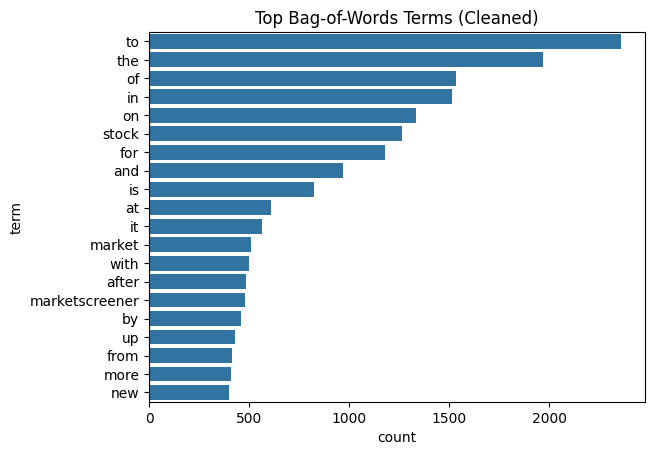

In [108]:
# Visualize top Bag of Words terms (Cleaned)
clean_bow_sum = np.array(X.sum(axis=0)).flatten()
clean_terms = bow.get_feature_names_out() # in older versions is get_feature_names()
clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum}).sort_values(by='count', ascending=False).head(20)

sns.barplot(data=clean_top, x='count', y='term')
plt.title("Top Bag-of-Words Terms (Cleaned)")
plt.show()

# Create Validation Set to Evaluate Model

In [109]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), sublinear_tf=True)
X = vectorizer.fit_transform(train['text'])
y = train['label']

In [110]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# LogisticRegression

In [111]:
model = LogisticRegression(class_weight='balanced', max_iter=2000, C=1.0)
model.fit(X_train_split, y_train_split)

LogisticRegression(class_weight='balanced', max_iter=2000)

# Evaluate on Validation Set

In [112]:
# Predict on training data
train_preds = model.predict(X_train_split)
print("Training set evaluation:")
print("Accuracy:", accuracy_score(y_train_split, train_preds))
print(classification_report(y_train_split, train_preds))

# Predict on validation data
val_preds = model.predict(X_val_split)
print("Validation set evaluation:")
print("Accuracy:", accuracy_score(y_val_split, val_preds))
print(classification_report(y_val_split, val_preds))

Training set evaluation:
Accuracy: 0.9034582132564841
              precision    recall  f1-score   support

           0       0.76      0.94      0.84      1154
           1       0.83      0.92      0.87      1538
           2       0.98      0.89      0.93      4942

    accuracy                           0.90      7634
   macro avg       0.86      0.92      0.88      7634
weighted avg       0.91      0.90      0.91      7634

Validation set evaluation:
Accuracy: 0.8093242535358827
              precision    recall  f1-score   support

           0       0.61      0.67      0.64       288
           1       0.72      0.74      0.73       385
           2       0.89      0.86      0.88      1236

    accuracy                           0.81      1909
   macro avg       0.74      0.76      0.75      1909
weighted avg       0.81      0.81      0.81      1909



# Transform Test Data and Predict

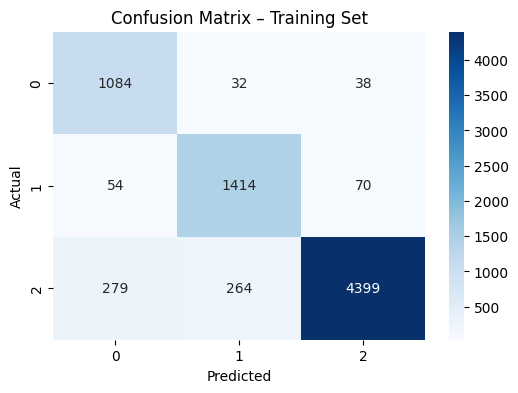

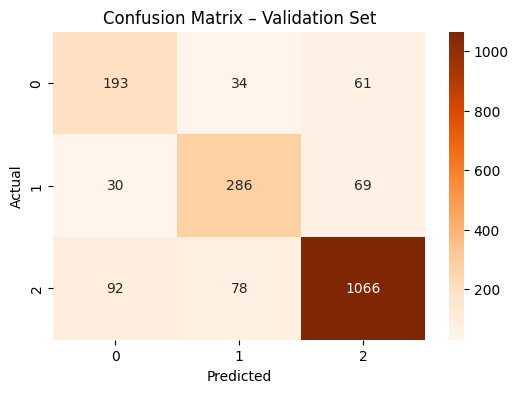

In [113]:
# Confusion Matrix for Training Data
train_cm = confusion_matrix(y_train_split, train_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.title('Confusion Matrix – Training Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion Matrix for Validation Data
val_cm = confusion_matrix(y_val_split, val_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Oranges', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.title('Confusion Matrix – Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**Training Set Confusion Matrix**

Most Neutral (2) are correctly predicted → Good

Bearish (0) and Bullish (1) get confused with each other and with Neutral

Still, most of the correct predictions lie on the diagonal

**Validation Set Confusion Matrix**

Neutral (2) class again dominates and is predicted well.

Bearish (0) is often misclassified as Neutral → 61 cases.

Bullish (1) also misclassified → especially as Neutral (74 cases).

# SVM

In [114]:
svm_clf = LinearSVC(class_weight='balanced', max_iter=2000)

svm_clf.fit(X_train_split, y_train_split)
svm_preds = svm_clf.predict(X_val_split)

# Training set evaluation
svm_train_preds = svm_clf.predict(X_train_split)
print("Training Accuracy:", accuracy_score(y_train_split, svm_train_preds))
print("Classification Report (Training Set):")
print(classification_report(y_train_split, svm_train_preds))

# Validation set evaluation
svm_val_preds = svm_clf.predict(X_val_split)
print("Validation Accuracy:", accuracy_score(y_val_split, svm_val_preds))
print("Classification Report (Validation Set):")
print(classification_report(y_val_split, svm_val_preds))

Training Accuracy: 0.9703955986376736
Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1154
           1       0.94      0.97      0.95      1538
           2       0.99      0.97      0.98      4942

    accuracy                           0.97      7634
   macro avg       0.95      0.97      0.96      7634
weighted avg       0.97      0.97      0.97      7634

Validation Accuracy: 0.8135149292823468
Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.66      0.61      0.63       288
           1       0.73      0.71      0.72       385
           2       0.87      0.89      0.88      1236

    accuracy                           0.81      1909
   macro avg       0.75      0.74      0.75      1909
weighted avg       0.81      0.81      0.81      1909



The model performs very well on the training data, with almost 97% accuracy, showing it learned the training examples very well. However, the accuracy drops to about 81% on the validation set, which means it doesn’t generalize perfectly to new data and might be overfitting. It also performs better on class 2 than on classes 0 and 1 in the validation set.

# XGBoost (Gradient Boosting)

In [115]:
# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=5, random_state=42)
xgb_model.fit(X_train_split, y_train_split)

# Training set evaluation
xgb_train_preds = xgb_model.predict(X_train_split)
print("Training Accuracy:", accuracy_score(y_train_split, xgb_train_preds))
print("Classification Report (Training Set):")
print(classification_report(y_train_split, xgb_train_preds))

# Validation set evaluation
xgb_val_preds = xgb_model.predict(X_val_split)
print("Validation Accuracy:", accuracy_score(y_val_split, xgb_val_preds))
print("Classification Report (Validation Set):")
print(classification_report(y_val_split, xgb_val_preds))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:19:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy: 0.8746397694524496
Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.96      0.58      0.73      1154
           1       0.94      0.72      0.81      1538
           2       0.85      0.99      0.92      4942

    accuracy                           0.87      7634
   macro avg       0.92      0.76      0.82      7634
weighted avg       0.89      0.87      0.87      7634

Validation Accuracy: 0.7920377160817181
Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.85      0.40      0.54       288
           1       0.78      0.54      0.64       385
           2       0.79      0.96      0.87      1236

    accuracy                           0.79      1909
   macro avg       0.81      0.63      0.68      1909
weighted avg       0.80      0.79      0.77      1909



The XGBoost model shows good performance on the training set with about 87% accuracy, but the validation accuracy drops to around 78%. This suggests some overfitting, where the model fits the training data well but struggles more with new data. The model does well on class 2 but has lower recall for classes 0 and 1 on the validation set, meaning it misses quite a few examples of those classes. Overall, the model is decent but could be improved to better generalize.

# Random Forest Classifier

In [116]:

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train_split, y_train_split)

# Training set evaluation
rf_train_preds = rf_model.predict(X_train_split)
print("Training Accuracy:", accuracy_score(y_train_split, rf_train_preds))
print("Classification Report (Training Set):")
print(classification_report(y_train_split, rf_train_preds))

# Validation set evaluation
rf_val_preds = rf_model.predict(X_val_split)
print("Validation Accuracy:", accuracy_score(y_val_split, rf_val_preds))
print("Classification Report (Validation Set):")
print(classification_report(y_val_split, rf_val_preds))

Training Accuracy: 0.9984280848834163
Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1154
           1       1.00      1.00      1.00      1538
           2       1.00      1.00      1.00      4942

    accuracy                           1.00      7634
   macro avg       1.00      1.00      1.00      7634
weighted avg       1.00      1.00      1.00      7634

Validation Accuracy: 0.7988475641697224
Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.83      0.41      0.55       288
           1       0.75      0.59      0.66       385
           2       0.81      0.95      0.87      1236

    accuracy                           0.80      1909
   macro avg       0.79      0.65      0.69      1909
weighted avg       0.80      0.80      0.78      1909



This model is almost perfect on the training data, with nearly 100% accuracy and perfect precision, recall, and F1 scores — which strongly indicates overfitting.

However, the validation results show a drop in performance to about 79% accuracy, with particularly low recall for classes 0 and 1. This means the model struggles to correctly identify many examples from those classes on unseen data.

In summary, the model memorizes the training set very well but doesn’t generalize effectively to new data, so it would benefit from regularization or more training data to reduce overfitting.

# KNN

In [117]:
# Train KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_split, y_train_split)

# Training set evaluation
knn_train_preds = knn_model.predict(X_train_split)
print("Training Accuracy:", accuracy_score(y_train_split, knn_train_preds))
print("Classification Report (Training Set):")
print(classification_report(y_train_split, knn_train_preds))

# Validation set evaluation
knn_val_preds = knn_model.predict(X_val_split)
print("Validation Accuracy:", accuracy_score(y_val_split, knn_val_preds))
print("Classification Report (Validation Set):")
print(classification_report(y_val_split, knn_val_preds))

Training Accuracy: 0.7266177626408173
Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.90      0.18      0.30      1154
           1       0.89      0.27      0.42      1538
           2       0.71      1.00      0.83      4942

    accuracy                           0.73      7634
   macro avg       0.83      0.48      0.52      7634
weighted avg       0.77      0.73      0.67      7634

Validation Accuracy: 0.6982713462545835
Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.86      0.11      0.19       288
           1       0.88      0.20      0.33       385
           2       0.69      0.99      0.81      1236

    accuracy                           0.70      1909
   macro avg       0.81      0.43      0.44      1909
weighted avg       0.75      0.70      0.62      1909



These results suggest the model is struggling overall, especially with classes 0 and 1:

- Training accuracy is about 73%, which is moderate, but the recall for classes 0 and 1 is very low (0.17 and 0.28), meaning the model misses most examples of these classes even in the training set.

- Class 2 is dominating the data (larger support) and has excellent recall (1.00) in training, which indicates the model is mostly learning to identify this class well.

- Validation accuracy drops further to ~70%, with similarly poor recall for classes 0 and 1, showing the model doesn’t generalize well and is biased toward the largest class.

- Macro F1 scores around 0.44–0.51 reveal poor balanced performance across classes, heavily influenced by the low scores on minority classes.

Summary: The model likely suffers from class imbalance and isn’t effectively learning the minority classes. Improvements could include better data balancing, feature engineering, or using algorithms better suited for imbalanced data.

# BERT

BERT (Bidirectional Encoder Representations from Transformers) is a transformer-based language model developed by Google. It understands the context of words in a sentence by looking at both directions (left and right), making it especially powerful for tasks like sentiment analysis, question answering, and classification.

We use the bert-base-uncased model provided by the Hugging Face Transformers library.

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
478/478 [==============================] - 146s 222ms/step - loss: 0.6570 - accuracy: 0.7417 - val_loss: 0.4971 - val_accuracy: 0.8104
Epoch 2/5
478/478 [==============================] - 102s 213ms/step - loss: 0.3923 - accuracy: 0.8592 - val_loss: 0.4493 - val_accuracy: 0.8287
Epoch 3/5
478/478 [==============================] - 103s 215ms/step - loss: 0.2654 - accuracy: 0.9061 - val_loss: 0.4691 - val_accuracy: 0.8387
Epoch 4/5
478/478 [==============================] - 103s 215ms/step - loss: 0.1858 - accuracy: 0.9411 - val_loss: 0.4892 - val_accuracy: 0.8339
Epoch 5/5
120/120 [==============================] - 7s 55ms/step - loss: 0.5035 - accuracy: 0.8376

✅ Training Accuracy: 0.9796
✅ Validation Accuracy: 0.8376


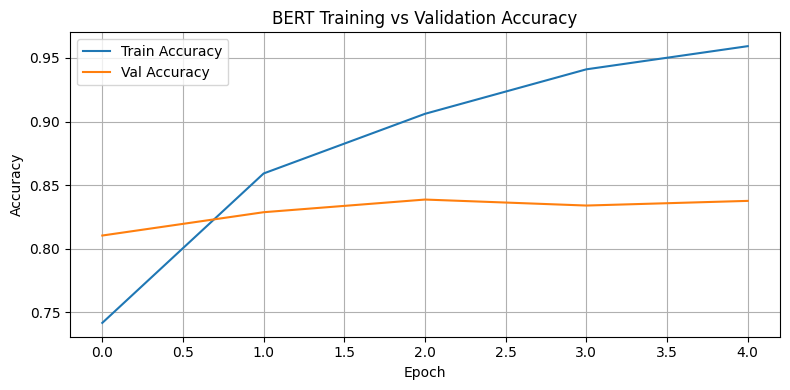

In [118]:

#Train-validation split again because we need our text to be "raw"
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    train['text'], train['label'],
    test_size=0.2,
    stratify=train['label'],
    random_state=42
)

train_texts = X_train_split.astype(str).tolist()
val_texts = X_val_split.astype(str).tolist()

#Load tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
num_labels = len(np.unique(y_train_split))
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

#Tokenize inputs
def encode_texts(texts, max_len=128):
    return tokenizer(
        texts,
        max_length=max_len,
        padding=True,
        truncation=True,
        return_tensors='tf'
    )

train_encodings = encode_texts(train_texts)
val_encodings = encode_texts(val_texts)

#Convert labels

y_train_tensor = tf.convert_to_tensor(y_train_split.values, dtype=tf.int32)
y_val_tensor = tf.convert_to_tensor(y_val_split.values, dtype=tf.int32)

#Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train_tensor))
train_dataset = train_dataset.shuffle(buffer_size=len(train_texts), seed=42).batch(16)

# For evaluation
train_dataset_eval = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train_tensor)).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_val_tensor)).batch(16)

#Create optimizer
batch_size = 16
epochs = 5
steps_per_epoch = len(train_texts) // batch_size
num_train_steps = steps_per_epoch * epochs

optimizer, schedule = create_optimizer(
    init_lr=1e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps
)

#Compile model
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

#Train
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

#Evaluate both sets
train_loss, train_acc = model.evaluate(train_dataset_eval)
val_loss, val_acc = model.evaluate(val_dataset)

print(f"\n✅ Training Accuracy: {train_acc:.4f}")
print(f"✅ Validation Accuracy: {val_acc:.4f}")

#Plot learning curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('BERT Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [119]:
#Evaluate on Validation
val_logits = model.predict(val_dataset).logits
val_preds = tf.argmax(val_logits, axis=1).numpy()
val_true = y_val_split.values

val_accuracy = accuracy_score(val_true, val_preds)
print(f"\n Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report (Validation Set):")
print(classification_report(val_true, val_preds, digits=4))

#Evaluate on Training
train_logits = model.predict(train_dataset_eval).logits
train_preds = tf.argmax(train_logits, axis=1).numpy()
train_true = y_train_split.values

train_accuracy = accuracy_score(train_true, train_preds)
print(f"\n Training Accuracy: {train_accuracy:.4f}")
print("Classification Report (Training Set):")
print(classification_report(train_true, train_preds, digits=4))


120/120 [==============================] - 10s 55ms/step

 Validation Accuracy: 0.8376
Classification Report (Validation Set):
              precision    recall  f1-score   support

           0     0.7007    0.6910    0.6958       288
           1     0.7818    0.7351    0.7577       385
           2     0.8844    0.9037    0.8940      1236

    accuracy                         0.8376      1909
   macro avg     0.7890    0.7766    0.7825      1909
weighted avg     0.8360    0.8376    0.8366      1909

478/478 [==============================] - 38s 73ms/step

 Training Accuracy: 0.9796
Classification Report (Training Set):
              precision    recall  f1-score   support

           0     0.9568    0.9593    0.9580      1154
           1     0.9700    0.9668    0.9684      1538
           2     0.9879    0.9883    0.9881      4942

    accuracy                         0.9796      7634
   macro avg     0.9715    0.9715    0.9715      7634
weighted avg     0.9796    0.9796    0.9796

### 📊 Model Performance on Validation Set

| Model               | Training Accuracy | Validation Accuracy | Validation Macro Avg F1-score |
|---------------------|-------------------|---------------------|-------------------------------|
| SVM                 | 0.97              | 0.81                | 0.74                          |
| XGBoost             | 0.87              | 0.78                | 0.66                          |
| Random Forest       | 1.00              | 0.79                | 0.69                          |
| KNN                 | 0.73              | 0.70                | 0.44                          |
| Logistic Regression | 0.89              | 0.80                | 0.71                          |
| **BERT**            | **0.97**          | **0.83**            | **0.77**                      |


**Best Model:**  
Based on validation accuracy and generalization, **BERT** performs best on the validation set despite unusual training accuracy — worth investigating. Logistic Regression and SVM also show solid, reliable results.



# Submit BERT predictions on test set

In [120]:
# 1. Prepare and encode test texts
test_texts = test['text'].astype(str).tolist()
test_encodings = encode_texts(test_texts)
test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_encodings)).batch(16)

# 2. Predict on test dataset
logits = model.predict(test_dataset).logits
predictions = np.argmax(logits, axis=1)

# 3. Add predictions to test DataFrame
test['predicted_label'] = predictions

# 4. Save to CSV for submission
test[['text', 'predicted_label']].to_csv('final_submission.csv', index=False)


150/150 [==============================] - 17s 94ms/step


In [121]:
label_counts = test['predicted_label'].value_counts()

print(label_counts)

predicted_label
2    1698
1     361
0     329
Name: count, dtype: int64
